## Demo 1. Standard Importance Sampling

Let q, π be two probability density functions on X such that π(x) > 0 ⇒ q(x) > 0. Then, for any set A such that π(A) > 0

$$
\pi(A) = \int_A \pi(x) \, dx
$$

$$
= \int_A \frac{\pi(x)}{q(x)} q(x) \, dx
$$

$$
= \int_A w(x) q(x) \, dx
$$

where $w : X \to \mathbb{R}^+$ is the so-called importance weight function: $w : x \mapsto \pi(x)/q(x)$. This identity can be obviously generalised to the expectation of any function. Assume $\pi(x) \phi(x) > 0 \Rightarrow q(x) > 0$, then

$$
I = \mathbb{E}_\pi(\phi(X)) = \int_X \phi(x) \pi(x) \, dx
$$

$$
= \int_X \phi(x) w(x) q(x) \, dx
$$

$$
= \mathbb{E}_q(\phi(X)w(X)).
$$

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np

tfd = tfp.distributions

In [2]:
def phi(x):
    """
    Test function φ(x) = sigmoid(x)
    
    This is the function for which we want to compute 𝔼_π[φ(X)].
    In other words, we want to know the expected value of φ(X) 
    when X is drawn from distribution π.
    
    Args:
        x: Input value(s) - can be a single number or tensor of numbers
        
    Returns:
        φ(x) = 1/(1 + e^(-x)) - the sigmoid function
        
    Example:
        φ(0) = 0.5
        φ(5) ≈ 0.993
        φ(-5) ≈ 0.007
    """
    return tf.nn.sigmoid(x) 

In [3]:
def importance_sampling(phi, pi_dist, q_dist, n_samples):
    """
    Estimate 𝔼_π[φ(X)] using two methods and compare them.
    
    Method 1 - Direct Monte Carlo:
        Sample X_i from π, compute (1/n)Σφ(X_i)
        This is the "standard" way - sample directly from the target distribution.
    
    Method 2 - Importance Sampling:
        Sample X_i from q, compute (1/n)Σφ(X_i)w(X_i) where w(x) = π(x)/q(x)
        This samples from a different distribution q and corrects using weights.
    
    Args:
        phi: Function φ to compute expectation of
        pi_dist: Target distribution π (TensorFlow probability distribution)
        q_dist: Proposal distribution q (TensorFlow probability distribution)
        n_samples: Number of Monte Carlo samples to draw
        
    Returns:
        Dictionary containing:
            - Estimates from both methods
            - Variance ratio (shows efficiency)
            - Samples and weights (for diagnostics)
    """
    
    # ========================================================================
    # Method 1: Direct sampling from π
    # ========================================================================
    # Goal: Estimate 𝔼_π[φ(X)] = ∫ φ(x)π(x)dx
    
    X_pi = pi_dist.sample(n_samples)       # Draw n_samples from distribution π
                                           # X_pi is a tensor of shape [n_samples]
                                           # Each element is an independent sample from π
    
    phi_direct = phi(X_pi)                 # Apply function φ to each sample
                                           # phi_direct[i] = φ(X_pi[i])
                                           # This gives us φ(X_1), φ(X_2), ..., φ(X_n)
    
    estimate_direct = tf.reduce_mean(phi_direct)  # Compute average: (1/n)Σφ(X_i)
                                                  # By Law of Large Numbers, this 
                                                  # converges to 𝔼_π[φ(X)] as n→∞
    
    variance_direct = tf.math.reduce_variance(phi_direct)  # Compute variance of estimates
                                                           # Lower variance = more precise
    
    # ========================================================================
    # Method 2: Importance sampling from q
    # ========================================================================
    # Goal: Estimate 𝔼_π[φ(X)] by sampling from q instead of π
    # Key idea: 𝔼_π[φ(X)] = 𝔼_q[φ(X)w(X)] where w(x) = π(x)/q(x)
    
    X_q = q_dist.sample(n_samples)         # Draw n_samples from proposal distribution q
                                           # Note: We're NOT sampling from π anymore!
                                           # X_q is a tensor of shape [n_samples]
    
    # Compute importance weights: w(x) = π(x)/q(x)
    # This corrects for sampling from q instead of π
    
    log_pi = pi_dist.log_prob(X_q)         # Compute log π(X_q[i]) for each sample
                                           # We use log probabilities for numerical stability
                                           # log_pi[i] = log(π(X_q[i]))
    
    log_q = q_dist.log_prob(X_q)           # Compute log q(X_q[i]) for each sample
                                           # log_q[i] = log(q(X_q[i]))
    
    log_w = log_pi - log_q                 # Compute log(π/q) = log(π) - log(q)
                                           # This is more stable than π/q directly
    
    w = tf.exp(log_w)                      # Convert back: w = exp(log(π/q)) = π/q
                                           # w[i] = π(X_q[i]) / q(X_q[i])
                                           # These are the importance weights
    
    phi_weighted = phi(X_q) * w            # Compute φ(X_i) × w(X_i) for each sample
                                           # phi_weighted[i] = φ(X_q[i]) × w[i]
    
    estimate_is = tf.reduce_mean(phi_weighted)  # Compute average: (1/n)Σφ(X_i)w(X_i)
                                                # By the importance sampling identity,
                                                # this also converges to 𝔼_π[φ(X)]
    
    variance_is = tf.math.reduce_variance(phi_weighted)  # Variance of IS estimator
                                                         # If q is good (close to π),
                                                         # this should be low
    
    # ========================================================================
    # Return all results
    # ========================================================================
    return {
        # Estimates
        'direct_est': estimate_direct.numpy(),     # Convert tensor to Python number
        'is_est': estimate_is.numpy(),             # Both should estimate the same value
        
        # Efficiency metric
        'variance_ratio': (variance_is / variance_direct).numpy(),  
        # Ratio < 1: IS is more efficient (lower variance)
        # Ratio > 1: Direct is more efficient
        # Ratio ≈ 1: Both equally efficient
        
        # Diagnostic data (for plotting and analysis)
        'samples_pi': X_pi.numpy(),                # Samples from π
        'samples_q': X_q.numpy(),                  # Samples from q
        'weights': w.numpy(),                      # Importance weights w(x)
        'phi_direct': phi_direct.numpy(),          # φ(X_i) values from direct method
        'phi_weighted': phi_weighted.numpy()       # φ(X_i)w(X_i) from IS method
    }


In [20]:
def print_results(results, mu_pi, sigma_pi, mu_q, sigma_q, n_samples):
    """
    Print a concise summary of the importance sampling results.
    
    Args:
        results: Dictionary from importance_sampling()
        mu_pi, sigma_pi: Parameters of target distribution
        mu_q, sigma_q: Parameters of proposal distribution
        n_samples: Number of samples used
    """
    
    # Print header with separator line
    print("\n" + "="*70)                    # Print 70 equal signs
    print("IMPORTANCE SAMPLING RESULTS")
    print("="*70)
    
    # Print what we're trying to estimate
    print(f"Goal: Estimate I = 𝔼_π[φ(X)] where φ(x) = sigmoid(x)")
    
    # Print setup information
    print(f"\nSetup:")
    print(f"  π(x) ~ N({mu_pi}, {sigma_pi}²)  [Target distribution]")
    print(f"  q(x) ~ N({mu_q}, {sigma_q}²)  [Proposal distribution]")
    print(f"  n = {n_samples} samples")
    
    # Print the mathematical identity being used
    print(f"\nIdentity: 𝔼_π[φ(X)] = 𝔼_q[φ(X)w(X)], where w(x) = π(x)/q(x)")
    
    # Print the numerical results
    print(f"\nResults:")
    print(f"  Direct from π:  {results['direct_est']:.6f}")  # :.6f means 6 decimal places
    print(f"  IS from q:      {results['is_est']:.6f}")
    print(f"  Variance Ratio: {results['variance_ratio']:.2f}x")  # :.2f means 2 decimal places
    
    # Print footer
    print("="*70 + "\n")

In [35]:
def plot_key_results(results, pi_dist, q_dist, mu_pi, sigma_pi, mu_q, sigma_q):
    """
    Plot the essential visualizations to understand importance sampling.
    
    Creates 2 plots:
    1. Distributions: Shows target π(x) vs proposal q(x)
    2. Convergence: Shows how both estimators converge as we add more samples
    
    Args:
        results: Dictionary from importance_sampling() function
        pi_dist: Target distribution π
        q_dist: Proposal distribution q
        mu_pi, sigma_pi: Mean and std of π (for labels)
        mu_q, sigma_q: Mean and std of q (for labels)
    """
    
    # Create a figure with 1 row and 2 columns of plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # axes[0] will be the left plot
    # axes[1] will be the right plot
    
    # ========================================================================
    # Plot 1: Target π(x) vs Proposal q(x)
    # ========================================================================
    # This shows how similar (or different) our proposal is from the target
    
    x_range = tf.linspace(-2.0, 8.0, 1000)  # Create 1000 points from -2 to 8
                                            # This gives us a smooth curve
    
    pi_pdf = tf.exp(pi_dist.log_prob(x_range)).numpy()  
    # For each point x in x_range, compute π(x)
    # log_prob gives log(π(x)), so we need exp to get π(x)
    # .numpy() converts TensorFlow tensor to NumPy array for plotting
    
    q_pdf = tf.exp(q_dist.log_prob(x_range)).numpy()
    # Same for q(x)
    
    # Plot the target distribution π(x) in blue solid line
    axes[0].plot(x_range, pi_pdf, 'b-', linewidth=2.5, 
                 label=f'π(x) ~ N({mu_pi}, {sigma_pi}²)')
    # 'b-' means blue solid line
    # linewidth=2.5 makes it thick enough to see
    # label is for the legend
    
    # Plot the proposal distribution q(x) in red dashed line
    axes[0].plot(x_range, q_pdf, 'r--', linewidth=2.5, 
                 label=f'q(x) ~ N({mu_q}, {sigma_q}²)')
    # 'r--' means red dashed line
    
    # Fill area under π(x) with semi-transparent blue
    axes[0].fill_between(x_range, pi_pdf, alpha=0.2, color='blue')
    # alpha=0.2 makes it 20% opaque (80% transparent)
    
    # Fill area under q(x) with semi-transparent red
    axes[0].fill_between(x_range, q_pdf, alpha=0.2, color='red')
    
    # Add labels and formatting
    axes[0].set_xlabel('x', fontsize=11)                   # X-axis label
    axes[0].set_ylabel('Density', fontsize=11)             # Y-axis label
    axes[0].set_title('Target π(x) vs Proposal q(x)',     # Title
                      fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=10)                            # Show legend
    axes[0].grid(True, alpha=0.3)                          # Add light grid
    
    # ========================================================================
    # Plot 2: Convergence of both estimators
    # ========================================================================
    # This shows how the estimates improve as we add more samples
    
    n = len(results['phi_direct'])         # Number of samples
    indices = np.arange(1, n + 1)          # [1, 2, 3, ..., n]
                                           # This is for the x-axis
    
    # Compute running average for direct method
    cumsum_direct = np.cumsum(results['phi_direct']) / indices
    # np.cumsum([a, b, c, d]) = [a, a+b, a+b+c, a+b+c+d]
    # Dividing by indices gives: [a/1, (a+b)/2, (a+b+c)/3, ...]
    # This is the running average: estimate after 1, 2, 3, ... samples
    
    # Compute running average for importance sampling
    cumsum_is = np.cumsum(results['phi_weighted']) / indices
    # Same logic, but for the weighted values
    
    # Plot direct sampling convergence in blue
    axes[1].plot(cumsum_direct, 'b-', linewidth=2, 
                 label='Direct from π', alpha=0.8)
    # alpha=0.8 makes it slightly transparent
    
    # Plot importance sampling convergence in red
    axes[1].plot(cumsum_is, 'r-', linewidth=2, 
                 label='IS from q', alpha=0.8)
    
    # Draw horizontal line at final direct estimate (blue dashed)
    axes[1].axhline(y=results['direct_est'], 
                    color='blue', linestyle='--', alpha=0.5)
    # axhline draws a horizontal line across the entire plot
    # This shows what value the blue curve is converging to
    
    # Draw horizontal line at final IS estimate (red dashed)
    axes[1].axhline(y=results['is_est'], 
                    color='red', linestyle='--', alpha=0.5)
    # Both should converge to approximately the same value!
    
    # Add labels and formatting
    axes[1].set_xlabel('Number of Samples', fontsize=11)
    axes[1].set_ylabel('𝔼_π[φ(X)]', fontsize=11)          # Y-axis is the estimate
    axes[1].set_title('Convergence', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Display the figure
    plt.show()

In [36]:
def demo(mu_pi, sigma_pi, mu_q, sigma_q, n_samples=1000):
    """
    Run a complete importance sampling demonstration.
    
    This is the main function you call to see everything in action.
    It creates the distributions, runs both methods, and shows results.
    
    Args:
        mu_pi: Mean of target distribution π
        sigma_pi: Standard deviation of π
        mu_q: Mean of proposal distribution q
        sigma_q: Standard deviation of q
        n_samples: How many samples to use (default 1000)
        
    Returns:
        results: Dictionary with all the numerical results
        
    Example:
        >>> demo(mu_pi=3.5, sigma_pi=1.0, mu_q=3.0, sigma_q=1.0)
    """
    
    # Create the target distribution π ~ Normal(mu_pi, sigma_pi²)
    pi_dist = tfd.Normal(loc=mu_pi, scale=sigma_pi)
    # loc = mean, scale = standard deviation
    
    # Create the proposal distribution q ~ Normal(mu_q, sigma_q²)
    q_dist = tfd.Normal(loc=mu_q, scale=sigma_q)
    
    # Run importance sampling (does both methods)
    results = importance_sampling(phi, pi_dist, q_dist, n_samples)
    
    # Display the results as text
    print_results(results, mu_pi, sigma_pi, mu_q, sigma_q, n_samples)
    
    # Display the results as plots
    plot_key_results(results, pi_dist, q_dist, mu_pi, sigma_pi, mu_q, sigma_q)
    
    # Return results in case user wants to analyze further
    return results


EXAMPLE 1: Good Proposal (q ≈ π)
----------------------------------------------------------------------

IMPORTANCE SAMPLING RESULTS
Goal: Estimate I = 𝔼_π[φ(X)] where φ(x) = sigmoid(x)

Setup:
  π(x) ~ N(3.5, 1.0²)  [Target distribution]
  q(x) ~ N(3.0, 1.0²)  [Proposal distribution]
  n = 1000 samples

Identity: 𝔼_π[φ(X)] = 𝔼_q[φ(X)w(X)], where w(x) = π(x)/q(x)

Results:
  Direct from π:  0.955953
  IS from q:      0.962508
  Variance Ratio: 153.88x



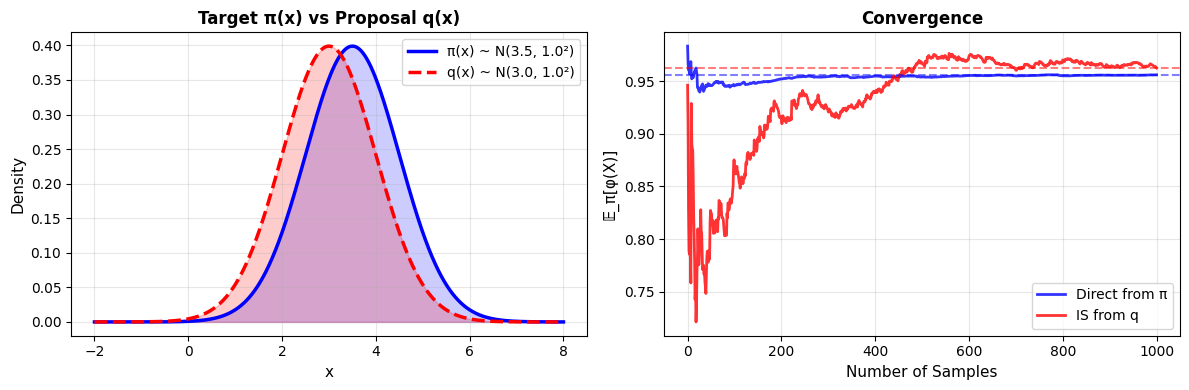


EXAMPLE 2: Poor Proposal (q far from π)
----------------------------------------------------------------------

IMPORTANCE SAMPLING RESULTS
Goal: Estimate I = 𝔼_π[φ(X)] where φ(x) = sigmoid(x)

Setup:
  π(x) ~ N(3.5, 1.0²)  [Target distribution]
  q(x) ~ N(1.0, 1.0²)  [Proposal distribution]
  n = 5000 samples

Identity: 𝔼_π[φ(X)] = 𝔼_q[φ(X)w(X)], where w(x) = π(x)/q(x)

Results:
  Direct from π:  0.954887
  IS from q:      0.854812
  Variance Ratio: 27792.97x



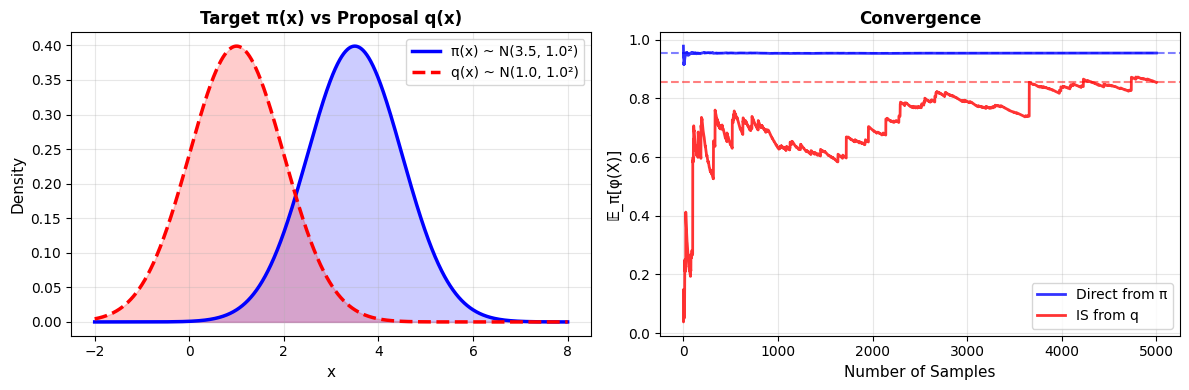


KEY INSIGHT:
  When q(x) ≈ π(x): Low variance, efficient sampling ✓
  When q(x) ≠ π(x): High variance, inefficient sampling ✗



In [37]:

if __name__ == "__main__":
    # This block only runs if you execute this file directly
    # (not if you import it as a module)
    
    print("\nEXAMPLE 1: Good Proposal (q ≈ π)")
    print("-" * 70)
    
    # Example 1: Proposal q is close to target π
    # π ~ N(3.5, 1)  and  q ~ N(3.0, 1)
    # The means differ by only 0.5, so q is a "good" proposal
    demo(mu_pi=3.5, sigma_pi=1.0, 
         mu_q=3.0, sigma_q=1.0, 
         n_samples=1000)
    
    print("\nEXAMPLE 2: Poor Proposal (q far from π)")
    print("-" * 70)
    
    # Example 2: Proposal q is far from target π
    # π ~ N(3.5, 1)  and  q ~ N(1.0, 1)
    # The means differ by 2.5, so q is a "poor" proposal
    # We use more samples (5000) to get stable results despite high variance
    demo(mu_pi=3.5, sigma_pi=1.0, 
         mu_q=1.0, sigma_q=1.0, 
         n_samples=5000)
    
    # Print the key takeaway message
    print("\nKEY INSIGHT:")
    print("  When q(x) ≈ π(x): Low variance, efficient sampling ✓")
    print("  When q(x) ≠ π(x): High variance, inefficient sampling ✗")
    print("="*70 + "\n")